**Installation**

In [ ]:
!pip install -q tensorflow-recommenders
#!pip install -q --upgrade tensorflow-datasets
!pip install --upgrade scikit-learn
!pip install -q tfds-nightly tensorflow matplotlib
!pip install nltk

     |████████████████████████████████| 85 kB 1.9 MB/s 
     |████████████████████████████████| 4.1 MB 5.4 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Libraries**

In [ ]:
import pandas as pd
import io
import string
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import re
import shutil
import string
import tensorflow as tf
import nltk
#import tensorflow_datasets as tfds
import sklearn

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
nltk.download('stopwords')

gpus = tf.config.list_physical_devices("GPU")
if gpus:
  print(len(gpus), "Logical GPUs")
  print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
  print("No GPU was detected. This code can be very slow without a GPU.")

# to make this notebook's output stable across runs
np.random.seed(20)
tf.random.set_seed(20)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
1 Logical GPUs
Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [ ]:
# Import other common libraries
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
import itertools
import re
import spacy

**Import Dataset** - Train and Test

In [ ]:
trainfile = "/content/drive/MyDrive/testGC/training.1600000.processed.noemoticon.csv"
testfile = "/content/drive/MyDrive/testGC/vaccination_all_tweets.csv"
train_columns = ['polarity','id','date','query_string','twitter_user','tweet']
test_columns = ['id','user_name','user_location','user_description','user_created','user_followers','user_friends','user_favourites','user_verified','date','text','hashtags','source','retweets','favorites','is_retweet']

In [ ]:
# Import Train data set
df_train = pd.read_csv(trainfile,
                 header=None, 
                 names=train_columns, 
                 encoding='latin-1')
df_train.head()

,polarity,id,date,query_string,twitter_user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Import Test data set
df_test = pd.read_csv(testfile,
                 encoding='latin-1',
                 low_memory=False)
df_test.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,elið±ð¹ðªðºð,Your Bed,"heil, hydra ðâº",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [ ]:
#train - choose only 3 columns
df_train = df_train[['date','tweet','polarity']]
df_train = df_train.dropna(subset=['tweet'])
df_train.head()

,date,tweet,polarity
0,Mon Apr 06 22:19:45 PDT 2009,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...,0
2,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Man...,0
3,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire,0
4,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all....",0


In [ ]:
#test - choose only 2 columns and 1 cols for sentiment
df_test = df_test[['date','text']]
df_test = df_test.dropna(subset=['text'])
df_test.loc[:,'polarity'] = np.nan

In [ ]:
df_test = df_test.rename({'text':'tweet'}, axis=1)
df_test.head()

,date,tweet,polarity
0,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,NaN
1,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN
2,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,NaN
3,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN
4,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,NaN


**Split Dataset**

In [ ]:
train_df, val_df = np.split(df_train.sample(frac=1), [int(0.9*len(df_train))])
test_df = df_test
print(len(train_df), 'training examples')
print(len(val_df), 'validation examples')
print(len(test_df), 'test examples')

1440000 training examples
160000 validation examples
202456 test examples


In [ ]:
#train_df_sample = train_df.sample(400000)
train_df_sample = train_df
X_train = train_df_sample.drop("polarity", axis=1) # drop labels for training set
y_train = train_df_sample["polarity"].copy()

In [ ]:
#val_df_sample = val_df.sample(32000)
val_df_sample = val_df
X_val = val_df_sample.drop("polarity", axis=1) # drop labels for validation set
y_val = val_df_sample["polarity"].copy()

In [ ]:
#test_df_sample = test_df.sample(20000)
test_df_sample = test_df
X_test = test_df_sample.drop("polarity", axis=1) # drop labels for test set
y_test = test_df_sample["polarity"].copy()

In [ ]:
print("X_train: " + str(X_train.shape) + str(type(X_train)))
print("y_train: "+ str(y_train.shape)+ str(type(y_train)))
print("X_val: " + str(X_val.shape) + str(type(X_val)))
print("y_val: "+ str(y_val.shape)+ str(type(y_val)))
print("X_test: " + str(X_test.shape) + str(type(X_test)))
print("y_test: "+ str(y_test.shape)+ str(type(y_test)))

X_train: (1440000, 2)<class 'pandas.core.frame.DataFrame'>
y_train: (1440000,)<class 'pandas.core.series.Series'>
X_val: (160000, 2)<class 'pandas.core.frame.DataFrame'>
y_val: (160000,)<class 'pandas.core.series.Series'>
X_test: (202456, 2)<class 'pandas.core.frame.DataFrame'>
y_test: (202456,)<class 'pandas.core.series.Series'>


**Preprocessing**

In [ ]:
# Punctuation Removal
punctuation_removal = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    # remove https links
    clean_tweet = re.sub(r'http\S+', '', text)
    # remove username
    clean_tweet = re.sub('@[^\s]+','', clean_tweet)
    # convert text to lowercase
    clean_tweet = clean_tweet.lower()
    # remove numbers
    clean_tweet = re.sub('\d', ' ', clean_tweet)
    # remove whitespaces
    clean_tweet = ' '.join(clean_tweet.split())

    return clean_tweet.translate(str.maketrans('', '', punctuation_removal))

In [ ]:
X_train["tweet"] = X_train["tweet"].apply(lambda text: remove_punctuation(text))

X_val["tweet"] = X_val["tweet"].apply(lambda text: remove_punctuation(text))

X_test["tweet"] = X_test["tweet"].apply(lambda text: remove_punctuation(text))

In [ ]:
#remove stopwords
stop_words = set(stopwords.words('english'))
X_train["tweet"] = X_train["tweet"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
X_val["tweet"] = X_val["tweet"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
X_test["tweet"] = X_test["tweet"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [ ]:
vocab_size = 50000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

**Label and Tweet Encoding**

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.fit_transform(y_val)
y_test = label_encoder.fit_transform(y_test)                     
y_train[:5]

array([0, 0, 1, 0, 0])

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train['tweet'])
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train['tweet'])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(X_val['tweet'])
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test['tweet'])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# Need this block to get it to work with TensorFlow 2.x
training_padded = np.array(train_padded)
training_labels = np.array(y_train)

val_padded = np.array(val_padded)
val_labels = np.array(y_val)

testing_padded = np.array(test_padded)
testing_labels = np.array(y_test)

**Model**

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           800000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 800,109
Trainable params: 800,109
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy())

**Execute Model**

In [ ]:
num_epochs = 10
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    #batch_size=128,
                    validation_data=(val_padded, val_labels),
                    verbose=1)

Epoch 1/10
45000/45000 [==============================] - 258s 6ms/step - loss: 0.4835 - binary_accuracy: 0.7718 - val_loss: 0.4618 - val_binary_accuracy: 0.7826
Epoch 2/10
45000/45000 [==============================] - 255s 6ms/step - loss: 0.4530 - binary_accuracy: 0.7879 - val_loss: 0.4723 - val_binary_accuracy: 0.7725
Epoch 3/10
45000/45000 [==============================] - 256s 6ms/step - loss: 0.4470 - binary_accuracy: 0.7916 - val_loss: 0.4592 - val_binary_accuracy: 0.7857
Epoch 4/10
45000/45000 [==============================] - 257s 6ms/step - loss: 0.4429 - binary_accuracy: 0.7945 - val_loss: 0.4593 - val_binary_accuracy: 0.7870
Epoch 5/10
45000/45000 [==============================] - 259s 6ms/step - loss: 0.4393 - binary_accuracy: 0.7965 - val_loss: 0.4578 - val_binary_accuracy: 0.7877
Epoch 6/10
45000/45000 [==============================] - 250s 6ms/step - loss: 0.4359 - binary_accuracy: 0.7990 - val_loss: 0.4599 - val_binary_accuracy: 0.7864
Epoch 7/10
45000/45000 [====

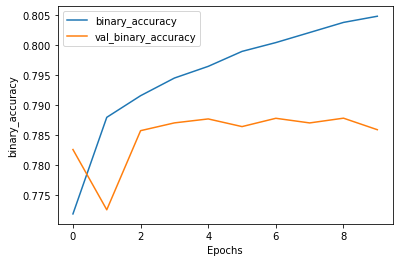

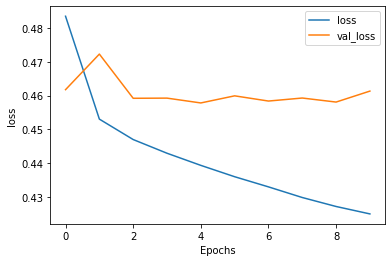

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "binary_accuracy")
plot_graphs(history, "loss")

**Evaluate the Model**

In [ ]:
predictions = model.predict(test_padded)
print(predictions)

[[0.35675636]
 [0.3891409 ]
 [0.50487375]
 ...
 [0.20353916]
 [0.87485033]
 [0.20353916]]


In [ ]:
df = pd.DataFrame(predictions, columns=['predictions'])
df.to_csv('prediction-remSW.csv', index=False)

In [ ]:
loss, accuracy = model.evaluate(testing_padded, testing_labels)

print("Loss: ", loss)
print("Accuracy: ", accuracy)


6327/6327 [==============================] - 21s 3ms/step - loss: 0.7842 - binary_accuracy: 0.5843
Loss:  0.7841603755950928
Accuracy:  0.5843294262886047


In [ ]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

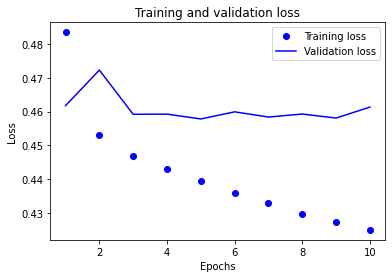

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


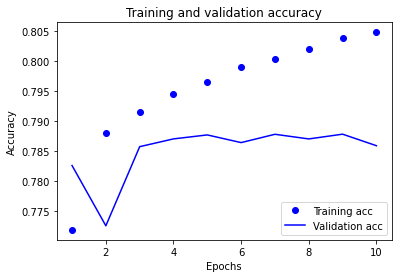

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()


**Check with SIA from NLTK**

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


True

In [ ]:
txt = remove_punctuation("work all day then out with her favorite people ever!")
seq = tokenizer.texts_to_sequences([txt])
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
print(pred)

[[0.4265509]]


In [ ]:
txt = "work all day then out with her favorite people ever!"
sid = SentimentIntensityAnalyzer()
ss = sid.polarity_scores(txt)
ss

{'compound': 0.5093, 'neg': 0.0, 'neu': 0.732, 'pos': 0.268}